In [2]:
import numpy as np
import pandas as pd
import math
from skimage import filters
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt
from skimage.morphology import erosion, dilation
from sklearn.metrics import accuracy_score

input_size = 784
output_size = 10
actFunc = "sigmoid"

#sizes = 10*np.ones(n) # sizes is sizes of hidden layer
sizes=np.array([300,300,300,300]) #output layer not mentioned 
sizes = sizes.astype(np.int64)
n=sizes.shape[0]
epocs = 20
alpha = 0.001

In [3]:
#reading data
data = pd.read_csv("train.csv")

In [4]:
data.shape[0]

55000

(300, 784)

In [90]:
data = data.sample(frac=1)

sub_data = data.head(data.shape[0]) #partial data
sub_data = sub_data.values
print(np.max(data.values[:,-1]))

9.0


In [91]:
ids = sub_data[:,1]
print(ids.shape)

images = sub_data[:,1:-1]
print(images.shape)

labels = sub_data[:,-1]
print(labels.shape)

labels = labels.astype(np.int64)

(55000,)
(55000, 784)
(55000,)


In [92]:
def preprocessing(img):
#     threshold = threshold_otsu(img)
#     th3 = img > threshold
#     #Plot
#     #plt.imshow(img, 'gray')
#     titles = ['Original', 'Otsu']
#     kernel = np.ones((2,2), np.uint8)
#     img_dilation = dilation(th3, kernel)
#     #plt.imshow(img_dilation, 'gray')
#     img_erosion = erosion(img_dilation)
# #     kernel = np.ones((2,1), np.uint8)
# #     img_dilation1 = dilation(img_erosion, kernel)
# #     img_erosion1 = erosion(img_dilation1)
#     plt.imshow(img_erosion)

    return img


In [93]:
images=np.reshape(images,[images.shape[0],28,28])
imag=images.copy()
for i in range(images.shape[0]):
    imag[i]=preprocessing(images[i])

In [94]:
images5=imag.copy()
images6=np.reshape(images5,[images5.shape[0],28*28])

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(images6)
images1 = scaler.transform(images6)
labels1 = labels

In [96]:
from sklearn.decomposition import PCA
pca = PCA(200)

pca.fit(images1)

images1 = pca.transform(images1)
input_size=200

In [97]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(images)
# images = scaler.transform(images)

In [98]:
images1.shape

(55000, 784)

In [99]:
weights=[]
for i in range(1, n+2):
    weights.append("W%s" %i);

print(weights)

In [100]:
bias=[]

for i in range(1, n+2):
    bias.append("b%s" %i);
    
print(bias)

pact=[]

for i in range(1, n+2):
    pact.append("a%s" %i);
    
print(pact)

act=[]

for i in range(1, n+2):
    act.append("h%s" %i);
    
print(act)

In [101]:
NN_dict = {}

In [102]:
#Initialization of weights
def initialize(NN_dict, sizes):
    n=sizes.shape[0]
    weights=[]
    for i in range(1, n+2):
        weights.append("W%s" %i);
    bias=[]

    for i in range(1, n+2):
        bias.append("b%s" %i);

    #print(bias)

    pact=[]

    for i in range(1, n+2):
        pact.append("a%s" %i);

    #print(pact)

    act=[]

    for i in range(1, n+2):
        act.append("h%s" %i);

    #print(act)
    
    NN_dict[weights[0]] = (np.random.random_sample((sizes[0],input_size))-0.5)*0.1 #*np.sqrt(2/((sizes[0]+input_size)))
    for i in range(1,n):
            NN_dict[weights[i]] = (np.random.random_sample((sizes[i],sizes[i-1]))-0.5)*0.1 #*np.sqrt(2/((sizes[i]+sizes[i-1])))
    NN_dict[weights[-1]] = (np.random.random_sample((output_size,sizes[-1]))-0.5)*0.1 #*np.sqrt(2/((output_size+sizes[-1])))
    for i in range(0,n):
        NN_dict[bias[i]] = ((np.random.random_sample(sizes[i]))-0.5)*0.01
    NN_dict[bias[-1]] = ((np.random.random_sample(output_size))-0.5)*0.01
    
    for i in range(0,n):
            NN_dict[pact[i]] = np.zeros(sizes[i])
    NN_dict[pact[-1]] = np.zeros(output_size)
    #print(NN_dict[pact[-1]].shape)    
    
    for i in range(0,n):
            NN_dict[act[i]] = np.zeros(sizes[i])
    NN_dict[act[-1]] = np.zeros(output_size)
    #print(NN_dict[act[-1]].shape)    
    
    
    return NN_dict, bias, weights, pact,act

In [103]:
#pact are a
#act are h
for i in range(0,n):
        NN_dict[pact[i]] = np.zeros(sizes[i])
NN_dict[pact[-1]] = np.zeros(output_size)
print(NN_dict[pact[-1]].shape)

In [104]:
for i in range(0,n):
        NN_dict[act[i]] = np.zeros(sizes[i])
NN_dict[act[-1]] = np.zeros(output_size)
print(NN_dict[act[-1]].shape)

In [105]:
def activation(x,func):
    if func is "sigmoid":
        return 1/(1 + np.exp(-x))
    elif func is "tanh":
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    elif func is "relu":
        x[x<0]=0
        return x
    
def output(x):
    return (np.exp(x))/np.sum(np.exp(x))

def gdash(x,func):
    if func is "sigmoid":
        return activation(x,func)*(1-activation(x,func))
    elif func is "tanh":
        return 1-activation(x,func)*activation(x,func)
    elif func is "relu":
        x[x<0]=0
        x[x>0]=1
        return x

In [106]:
def predict(input_x):    
    NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)
    NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

    for p in range(1,n):
        #print("c",NN_dict[act[p-1]].shape)
        NN_dict[pact[p]] = NN_dict[bias[p]]+np.matmul(NN_dict[weights[p]],NN_dict[act[p-1]])
        #print("c",NN_dict[act[k-1]].shape)
        NN_dict[act[p]] = activation(NN_dict[pact[p]],actFunc)

        #print("a",p)
    NN_dict[pact[n]] = NN_dict[bias[n]]+np.matmul(NN_dict[weights[n]],NN_dict[act[n-1]])
    NN_dict[act[n]] = output(NN_dict[pact[n]])
    
    return np.argmax(NN_dict[act[n]])
        

In [107]:
def gradientdescent(epocs,images1,NN_dict,labels1):
    losse=[]
    for j in range(0,epocs):
        gradWkVecSum = np.array([])
        gradbkVecSum = np.array([])

        for i in range(0,images.shape[0]):    
            input_x = images1[i]
            label = labels1[i]

            #Forward-Prop 

            NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)
            NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

            for p in range(1,n):
                #print("c",NN_dict[act[p-1]].shape)
                NN_dict[pact[p]] = NN_dict[bias[p]]+np.matmul(NN_dict[weights[p]],NN_dict[act[p-1]])
                #print("c",NN_dict[act[k-1]].shape)
                NN_dict[act[p]] = activation(NN_dict[pact[p]],actFunc)

            #print("a",p)
            NN_dict[pact[n]] = NN_dict[bias[n]]+np.matmul(NN_dict[weights[n]],NN_dict[act[n-1]])
            NN_dict[act[n]] = output(NN_dict[pact[n]])

            #print("a",NN_dict[pact[-1]])
            #Backward-Prop
            

            gradWkVec = []
            gradbkVec = []

            gradak = -(np.eye(1,output_size,label).T[:,0] - NN_dict[act[n]])
            
            for k in range(n, 0, -1):
                # Computing gradient w.r.t. parameters;
                gradWk = np.matmul(gradak[np.newaxis].T,NN_dict[act[k-1]][np.newaxis]) 
                
                gradbk = gradak.copy()

                #print(NN_dict[act[k-1]])

                #print(act[k-1])

                gradWkVec.append(gradWk)
                gradbkVec.append(gradbk)

                # Computing gradient w.r.t. layer below;
                gradhkm1 = np.matmul(np.transpose(NN_dict[weights[k]]),gradak)

                # Computing gradient w.r.t. layer below (pre-activation);
                gradak = np.multiply(gradhkm1, gdash(NN_dict[pact[k-1]],actFunc))
                #print("a",gradak.shape)
                #print("b",gradhkm1.shape)
                #print("v",gdash(NN_dict[pact[k-1]],actFunc).shape)

            gradWk = np.matmul(gradak[np.newaxis].T,input_x[np.newaxis])    
            gradbk = gradak.copy()

            

            gradWkVec.append(gradWk)
            gradbkVec.append(gradbk)

            if i is 0:
                gradWkVecSum = gradWkVec.copy()
                gradbkVecSum = gradbkVec.copy()
            else:
                for m in range(0,len(gradWkVecSum)):
                    gradWkVecSum[m] = gradWkVecSum[m] + gradWkVec[m]


         #Update rule


        for l in range(0,n):
            #print(l)
            NN_dict[weights[l]] = NN_dict[weights[l]] - alpha*gradWkVecSum[n-l]
            NN_dict[bias[l]] = NN_dict[bias[l]] - alpha*gradbkVecSum[n-l]




        #Loss-calc

        loss = 0

        for t in range(0,images.shape[0]):    
            input_x = images1[t]
            label = labels1[t] 
            NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)
            #print("q",NN_dict[weights[0]].shape,input_x.shape)
            #print("a",NN_dict[pact[0]])
            NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)
            #print("a2",NN_dict[act[0]])

            for k in range(1,n):
                #print("c",NN_dict[act[k-1]].shape)
                NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
                #print("c",NN_dict[act[k-1]])
                NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

            NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
            NN_dict[act[-1]] = output(NN_dict[pact[-1]])

            loss = loss-math.log(NN_dict[act[-1]][label])

        print(loss/images1.shape[0])
        losse.append(loss)
    return losse , NN_dict

## Gradient Descent batch size

In [108]:
def gradientdescent2(epocs,images1,NN_dict,batchsize,alpha,labels1,images11,labels11,bias, weights, pact,act, n):
    losse=[]
    lossv=[]
    om=0
    loss = 0

    for t in range(0,images1.shape[0]):    
        input_x = images1[t]
        label = labels1[t] 
        NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

        NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

        for k in range(1,n):
            NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
            NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

        NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
        NN_dict[act[-1]] = output(NN_dict[pact[-1]])

        loss = loss-math.log(NN_dict[act[-1]][label])
    loss=loss/images1.shape[0]
    print(loss)
    losse.append(loss)

    loss1 = 0

    for p in range(0,images11.shape[0]):    
        input_x = images11[p]
        label = labels11[p] 
        NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

        NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

        for k in range(1,n):
            NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
            NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

        NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
        NN_dict[act[-1]] = output(NN_dict[pact[-1]])
        loss1 = loss1-math.log(NN_dict[act[-1]][label])
        
    loss1=loss1/images11.shape[0]
    #print(images1.shape[0])
    print(loss1)
    lossv.append(loss1)
    for j in range(0,epocs):
        gradWkVecSum = np.array([])
        gradbkVecSum = np.array([])
        
        for q in range(0,images1.shape[0],batchsize):
            for i in range(q,q+batchsize):
                input_x = images1[i]
                label = labels1[i]

                #Forward-Prop 

                NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)
                NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

                for p in range(1,n):
                    NN_dict[pact[p]] = NN_dict[bias[p]]+np.matmul(NN_dict[weights[p]],NN_dict[act[p-1]])
                    NN_dict[act[p]] = activation(NN_dict[pact[p]],actFunc)

                NN_dict[pact[n]] = NN_dict[bias[n]]+np.matmul(NN_dict[weights[n]],NN_dict[act[n-1]])
                NN_dict[act[n]] = output(NN_dict[pact[n]])

                #Backward-Prop

                gradWkVec = []
                gradbkVec = []

                gradak = -(np.eye(1,output_size,labels1[i]).T[:,0] - NN_dict[act[-1]])

                for k in range(n, 0, -1):
                    # Computing gradient w.r.t. parameters;
                    gradWk = np.matmul(gradak[np.newaxis].T,NN_dict[act[k-1]][np.newaxis]) #+0.01*NN_dict[weights[k]]  
                    gradbk = gradak.copy()

                    gradWkVec.append(gradWk)
                    gradbkVec.append(gradbk)

                    # Computing gradient w.r.t. layer below;
                    gradhkm1 = np.matmul(np.transpose(NN_dict[weights[k]]),gradak)

                    # Computing gradient w.r.t. layer below (pre-activation);
                    gradak = np.multiply(gradhkm1, gdash(NN_dict[pact[k-1]],actFunc))

                gradWk = np.matmul(gradak[np.newaxis].T,input_x[np.newaxis])    
                gradbk = gradak.copy()


                gradWkVec.append(gradWk)
                gradbkVec.append(gradbk)

                if i is 0:
                    gradWkVecSum = gradWkVec.copy()
                    gradbkVecSum = gradbkVec.copy()
                else:
                    for m in range(0,len(gradWkVecSum)):
                        gradWkVecSum[m] = gradWkVecSum[m] + gradWkVec[m]
                        gradbkVecSum[m] = gradbkVecSum[m] + gradbkVec[m]           
                
            #Update rule

            for l in range(0,n):
                om=om+1
                NN_dict[weights[l]] = NN_dict[weights[l]] - alpha*gradWkVecSum[n-l]
                NN_dict[bias[l]] = NN_dict[bias[l]] - alpha*gradbkVecSum[n-l]


        #Loss-calc

        loss = 0

        for t in range(0,images1.shape[0]):    
            input_x = images1[t]
            label = labels1[t] 
            NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

            NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

            for k in range(1,n):
                NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
                NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

            NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
            NN_dict[act[-1]] = output(NN_dict[pact[-1]])

            loss = loss-math.log(NN_dict[act[-1]][label])
        loss=loss/images1.shape[0]
        print(loss)
        losse.append(loss)
        
        loss1 = 0

        for p in range(0,images11.shape[0]):    
            input_x = images11[p]
            label = labels11[p] 
            NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

            NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

            for k in range(1,n):
                NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
                NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

            NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
            NN_dict[act[-1]] = output(NN_dict[pact[-1]])

            loss1 = loss1-math.log(NN_dict[act[-1]][label])
        loss1=loss1/images2.shape[0]
        #print(images1.shape[0])
        print(loss1)
        lossv.append(loss1)
        
    return losse , lossv, NN_dict

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(images)
images1  = images.copy()
labels1 = labels.copy()

In [110]:
epocs=10
batchsize=20
alpha=0.001
size=np.array([[300,300,300,300]])
size = sizes.astype(np.int64)
NN_dict, bias, weights, pact,act = initialize(NN_dict,size)
#loss_grad1 , NN_dict= gradientdescent(epocs,images1,NN_dict,labels1)
loss_grad1 ,loss_gradv1, NN_dict= gradientdescent2(epocs,images1,NN_dict,batchsize,alpha,labels1,images2,labels2,bias, weights, pact,act, n)

In [111]:
ypre=[]
for i in range(images1.shape[0]):
    ypre.append(predict(images1[i]))
from sklearn.metrics import accuracy_score
print(accuracy_score(labels1, ypre))

In [112]:
# print(set(ypre))
# images1.shape

## Momentum bases GD batch wise

In [113]:
def momentum2(epocs,images1,NN_dict,batchsize,alpha,labels1,images11,labels11,bias, weights, pact,act, n,eta):
    losse=[]
    sumgradW=[]
    sumgradb=[]
    lossv=[]
    om=0
    loss = 0

    for t in range(0,images1.shape[0]):    
        input_x = images1[t]
        label = labels1[t] 
        NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

        NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

        for k in range(1,n):
            NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
            NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

        NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
        NN_dict[act[-1]] = output(NN_dict[pact[-1]])

        loss = loss-math.log(NN_dict[act[-1]][label])
    loss=loss/images1.shape[0]
    print(loss)
    losse.append(loss)

    loss1 = 0

    for p in range(0,images11.shape[0]):    
        input_x = images11[p]
        label = labels11[p] 
        NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

        NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

        for k in range(1,n):
            NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
            NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

        NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
        NN_dict[act[-1]] = output(NN_dict[pact[-1]])
        loss1 = loss1-math.log(NN_dict[act[-1]][label])
        
    loss1=loss1/images11.shape[0]
    #print(images1.shape[0])
    print(loss1)
    lossv.append(loss1)
    for j in range(0,epocs):
        gradWkVecSum = np.array([])
        gradbkVecSum = np.array([])

        for q in range(0,images.shape[0],batchsize):
            for i in range(q,q+batchsize):
                input_x = images[i]
                label = labels[i]

                #Forward-Prop 

                NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)
                NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

                for p in range(1,n):
                    #print("c",NN_dict[act[p-1]].shape)
                    NN_dict[pact[p]] = NN_dict[bias[p]]+np.matmul(NN_dict[weights[p]],NN_dict[act[p-1]])
                    #print("c",NN_dict[act[k-1]].shape)
                    NN_dict[act[p]] = activation(NN_dict[pact[p]],actFunc)

                #print("a",p)
                NN_dict[pact[n]] = NN_dict[bias[n]]+np.matmul(NN_dict[weights[n]],NN_dict[act[n-1]])
                NN_dict[act[n]] = output(NN_dict[pact[n]])

                #print("a",NN_dict[pact[-1]])
                #Backward-Prop

                gradWkVec = []
                gradbkVec = []

                gradak = -(np.eye(1,output_size,labels[i]).T[:,0] - NN_dict[act[-1]])
                #print("x",NN_dict[act[-1]].shape)
                #print("w",gradak.shape)

                for k in range(n, 0, -1):
                    # Computing gradient w.r.t. parameters;
                    gradWk = np.matmul(gradak[np.newaxis].T,NN_dict[act[k-1]][np.newaxis])    
                    gradbk = gradak.copy()

                    #print(NN_dict[act[k-1]])

                    #print(act[k-1])

                    gradWkVec.append(gradWk)
                    gradbkVec.append(gradbk)

                    # Computing gradient w.r.t. layer below;
                    gradhkm1 = np.matmul(np.transpose(NN_dict[weights[k]]),gradak)

                    # Computing gradient w.r.t. layer below (pre-activation);
                    gradak = np.multiply(gradhkm1, gdash(NN_dict[pact[k-1]],actFunc))
                    #print("a",gradak.shape)
                    #print("b",gradhkm1.shape)
                    #print("v",gdash(NN_dict[pact[k-1]],actFunc).shape)

                gradWk = np.matmul(gradak[np.newaxis].T,input_x[np.newaxis])    
                gradbk = gradak.copy()

                #print(gradbk.shape)

                gradWkVec.append(gradWk)
                gradbkVec.append(gradbk)

                if i is 0:
                    gradWkVecSum = gradWkVec.copy()
                    gradbkVecSum = gradbkVec.copy()
                else:
                    for m in range(0,len(gradWkVecSum)):
                        gradWkVecSum[m] = gradWkVecSum[m] + gradWkVec[m]
                        gradbkVecSum[m] = gradbkVecSum[m] + gradbkVec[m]


            #Update rule
            if(j is 0):
                if( q is 0):
                    sumgradW , sumgradb = gradWkVecSum.copy() , gradbkVecSum.copy()
            else:
                for m in range(0,len(gradWkVecSum)):
                    sumgradW[m] = gradWkVecSum[m] + eta*sumgradW[m]
                    sumgradb[m] = gradbkVecSum[m] + eta*sumgradb[m]

            for l in range(0,n):
                #print(l)
                NN_dict[weights[l]] = NN_dict[weights[l]] - alpha*sumgradW[n-l]
                NN_dict[bias[l]] = NN_dict[bias[l]] - alpha*sumgradb[n-l]



        #Loss-calc

        loss = 0

        for t in range(0,images1.shape[0]):    
            input_x = images1[t]
            label = labels1[t] 
            NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

            NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

            for k in range(1,n):
                NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
                NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

            NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
            NN_dict[act[-1]] = output(NN_dict[pact[-1]])

            loss = loss-math.log(NN_dict[act[-1]][label])
        loss=loss/images1.shape[0]
        print(loss)
        losse.append(loss)

        loss1 = 0

        for p in range(0,images11.shape[0]):    
            input_x = images11[p]
            label = labels11[p] 
            NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

            NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

            for k in range(1,n):
                NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
                NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

            NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
            NN_dict[act[-1]] = output(NN_dict[pact[-1]])
            loss1 = loss1-math.log(NN_dict[act[-1]][label])

        loss1=loss1/images11.shape[0]
        #print(images1.shape[0])
        print(loss1)
        lossv.append(loss1)
    return losse ,lossv, NN_dict

In [114]:
epocs=10
batchsize=20
eta=0.9
alpha=0.001
NN_dict, bias, weights, pact,act = initialize(NN_dict,size)
size=np.array([[300,300,300,300]])
size = sizes.astype(np.int64)
loss_moment1 ,loss_momentv1, NN_dict= momentum2(epocs,images1,NN_dict,batchsize,alpha,labels1,images2,labels2,bias, weights, pact,act, n,eta)

## Nag GD batchwise

In [115]:
def nag2(epocs,images1,NN_dict,batchsize,alpha,labels1,images11,labels11,bias, weights, pact,act, n,eta):
    losse=[]
    om=0
    sumgradW=[]
    sumgradb=[]
    lossv=[]
    om=0
    loss = 0

    for t in range(0,images1.shape[0]):    
        input_x = images1[t]
        label = labels1[t] 
        NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

        NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

        for k in range(1,n):
            NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
            NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

        NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
        NN_dict[act[-1]] = output(NN_dict[pact[-1]])

        loss = loss-math.log(NN_dict[act[-1]][label])
    loss=loss/images1.shape[0]
    print(loss)
    losse.append(loss)

    loss1 = 0

    for p in range(0,images11.shape[0]):    
        input_x = images11[p]
        label = labels11[p] 
        NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

        NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

        for k in range(1,n):
            NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
            NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

        NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
        NN_dict[act[-1]] = output(NN_dict[pact[-1]])
        loss1 = loss1-math.log(NN_dict[act[-1]][label])
        
    loss1=loss1/images11.shape[0]
    #print(images1.shape[0])
    print(loss1)
    lossv.append(loss1)
    for j in range(0,epocs):
        gradWkVecSum = np.array([])
        gradbkVecSum = np.array([])

        for q in range(0,images.shape[0],batchsize):
            for i in range(q,q+batchsize):
                input_x = images[i]
                label = labels[i]

                #Forward-Prop 

                NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)
                NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

                for p in range(1,n):
                    #print("c",NN_dict[act[p-1]].shape)
                    NN_dict[pact[p]] = NN_dict[bias[p]]+np.matmul(NN_dict[weights[p]],NN_dict[act[p-1]])
                    #print("c",NN_dict[act[k-1]].shape)
                    NN_dict[act[p]] = activation(NN_dict[pact[p]],actFunc)

                #print("a",p)
                NN_dict[pact[n]] = NN_dict[bias[n]]+np.matmul(NN_dict[weights[n]],NN_dict[act[n-1]])
                NN_dict[act[n]] = output(NN_dict[pact[n]])

                #print("a",NN_dict[pact[-1]])
                #Backward-Prop

                gradWkVec = []
                gradbkVec = []

                gradak = -(np.eye(1,output_size,labels[i]).T[:,0] - NN_dict[act[-1]])
                #print("x",NN_dict[act[-1]].shape)
                #print("w",gradak.shape)

                for k in range(n, 0, -1):
                    # Computing gradient w.r.t. parameters;
                    gradWk = np.matmul(gradak[np.newaxis].T,NN_dict[act[k-1]][np.newaxis])    
                    gradbk = gradak

                    #print(NN_dict[act[k-1]])

                    #print(act[k-1])

                    gradWkVec.append(gradWk)
                    gradbkVec.append(gradbk)

                    # Computing gradient w.r.t. layer below;
                    gradhkm1 = np.matmul(np.transpose(NN_dict[weights[k]]),gradak)

                    # Computing gradient w.r.t. layer below (pre-activation);
                    gradak = np.multiply(gradhkm1, gdash(NN_dict[pact[k-1]],actFunc))
                    #print("a",gradak.shape)
                    #print("b",gradhkm1.shape)
                    #print("v",gdash(NN_dict[pact[k-1]],actFunc).shape)

                gradWk = np.matmul(gradak[np.newaxis].T,input_x[np.newaxis])    
                gradbk = gradak

                #print(gradbk.shape)

                gradWkVec.append(gradWk)
                gradbkVec.append(gradbk)

                if i is 0:
                    gradWkVecSum = gradWkVec.copy()
                    gradbkVecSum = gradbkVec.copy()
                else:
                    for m in range(0,len(gradWkVecSum)):
                        gradWkVecSum[m] = gradWkVecSum[m] + gradWkVec[m]


            #Update rule
            if(j is 0):
                if q is 0:
                    sumgradW , sumgradb = gradWkVecSum.copy() , gradbkVecSum.copy()
            else:
                for m in range(0,len(gradWkVecSum)):
                    sumgradW[m] =  eta*sumgradW[m]
                    sumgradb[m] =  eta*sumgradb[m]

            for l in range(0,n):
                om=om+1
                #print(l)
                NN_dict[weights[l]] = NN_dict[weights[l]] - alpha*sumgradW[n-l]
                NN_dict[bias[l]] = NN_dict[bias[l]] - alpha*sumgradb[n-l]


            for i in range(q,q+batchsize):
                input_x = images[i]
                label = labels[i]

                #Forward-Prop 

                NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)
                NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

                for p in range(1,n):
                    #print("c",NN_dict[act[p-1]].shape)
                    NN_dict[pact[p]] = NN_dict[bias[p]]+np.matmul(NN_dict[weights[p]],NN_dict[act[p-1]])
                    #print("c",NN_dict[act[k-1]].shape)
                    NN_dict[act[p]] = activation(NN_dict[pact[p]],actFunc)

                #print("a",p)
                NN_dict[pact[n]] = NN_dict[bias[n]]+np.matmul(NN_dict[weights[n]],NN_dict[act[n-1]])
                NN_dict[act[n]] = output(NN_dict[pact[n]])

                #print("a",NN_dict[pact[-1]])
                #Backward-Prop

                gradWkVec = []
                gradbkVec = []

                gradak = -(np.eye(1,output_size,labels[i]).T[:,0] - NN_dict[act[-1]])
                #print("x",NN_dict[act[-1]].shape)
                #print("w",gradak.shape)

                for k in range(n, 0, -1):
                    # Computing gradient w.r.t. parameters;
                    gradWk = np.matmul(gradak[np.newaxis].T,NN_dict[act[k-1]][np.newaxis])    
                    gradbk = gradak

                    #print(NN_dict[act[k-1]])

                    #print(act[k-1])

                    gradWkVec.append(gradWk)
                    gradbkVec.append(gradbk)

                    # Computing gradient w.r.t. layer below;
                    gradhkm1 = np.matmul(np.transpose(NN_dict[weights[k]]),gradak)

                    # Computing gradient w.r.t. layer below (pre-activation);
                    gradak = np.multiply(gradhkm1, gdash(NN_dict[pact[k-1]],actFunc))
                    #print("a",gradak.shape)
                    #print("b",gradhkm1.shape)
                    #print("v",gdash(NN_dict[pact[k-1]],actFunc).shape)

                gradWk = np.matmul(gradak[np.newaxis].T,input_x[np.newaxis])    
                gradbk = gradak

                #print(gradbk.shape)

                gradWkVec.append(gradWk)
                gradbkVec.append(gradbk)

                if i is 0:
                    gradWkVecSum = gradWkVec.copy()
                    gradbkVecSum = gradbkVec.copy()
                else:
                    for m in range(0,len(gradWkVecSum)):
                        gradWkVecSum[m] = gradWkVecSum[m] + gradWkVec[m]


            #Update rule
            for m in range(0,len(gradWkVecSum)):
                sumgradW[m] = gradWkVecSum[m] + eta*sumgradW[m]
                sumgradb[m] = gradbkVecSum[m] + eta*sumgradb[m]

            for l in range(0,n):
                om=om+1
                #print(l)
                NN_dict[weights[l]] = NN_dict[weights[l]] - alpha*sumgradW[n-l]
                NN_dict[bias[l]] = NN_dict[bias[l]] - alpha*sumgradb[n-l]

        #Loss-calc

        loss = 0

        for t in range(0,images1.shape[0]):    
            input_x = images1[t]
            label = labels1[t] 
            NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

            NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

            for k in range(1,n):
                NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
                NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

            NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
            NN_dict[act[-1]] = output(NN_dict[pact[-1]])

            loss = loss-math.log(NN_dict[act[-1]][label])
        loss=loss/images1.shape[0]
        print(loss)
        losse.append(loss)

        loss1 = 0

        for p in range(0,images11.shape[0]):    
            input_x = images11[p]
            label = labels11[p] 
            NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

            NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

            for k in range(1,n):
                NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
                NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

            NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
            NN_dict[act[-1]] = output(NN_dict[pact[-1]])
            loss1 = loss1-math.log(NN_dict[act[-1]][label])

        loss1=loss1/images11.shape[0]
        #print(images1.shape[0])
        print(loss1)
        lossv.append(loss1)
    
    return losse ,lossv, NN_dict

In [116]:
epocs=10
batchsize=20
eta=0.9
#NN_dict, bias, weights, pact,act = initialize(NN_dict,size)
size=np.array([[300,300,300,300]])
size = sizes.astype(np.int64)
loss_nag1 ,loss_nagv1, NN_dict= nag2(epocs,images1,NN_dict,batchsize,alpha,labels1,images2,labels2,bias, weights, pact,act, n,eta)

## Adam

In [117]:
def adam(epocs,images1,NN_dict,batchsize,beta1,beta2,eps,alpha,actfunc,labels1, images11, labels11, bias, weights, pact,act, n,lamda):
    losse=[]
    lossv=[]
    
    sumgradW=[]
    sumgradb=[]
    respropW=[]
    respropb=[]
    t=0
    loss = 0

    for p in range(0,images1.shape[0]):    
        input_x = images1[p]
        label = labels1[p] 
        NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)
        #print("q",NN_dict[weights[0]].shape,input_x.shape)
        #print("a",NN_dict[pact[0]])
        NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)
        #print("a2",NN_dict[act[0]])

        for k in range(1,n):
            #print("c",NN_dict[act[k-1]].shape)
            NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
            #print("c",NN_dict[act[k-1]])
            NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)
            
            

        NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
        NN_dict[act[-1]] = output(NN_dict[pact[-1]])

        loss = loss-math.log(NN_dict[act[-1]][label])
    loss=loss/images1.shape[0]
    #print(images1.shape[0])
    print(loss)
    losse.append(loss)


    loss1 = 0

    for p in range(0,images11.shape[0]):    
        input_x = images11[p]
        label = labels11[p] 
        NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

        NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

        for k in range(1,n):
            NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
            NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

        NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
        NN_dict[act[-1]] = output(NN_dict[pact[-1]])

        loss1 = loss1-math.log(NN_dict[act[-1]][label])
    loss1=loss1/images2.shape[0]
    #print(images1.shape[0])
    print(loss1)
    lossv.append(loss1)
    for j in range(0,epocs):
        gradWkVecSum = np.array([])
        gradbkVecSum = np.array([])
        for q in range(0,images1.shape[0],batchsize):
            for i in range(q,q+batchsize):
                input_x = images1[i]
                label = labels1[i]

                #Forward-Prop 

                NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)
                NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

                for p in range(1,n):
                    #print("c",NN_dict[act[p-1]].shape)
                    NN_dict[pact[p]] = NN_dict[bias[p]]+np.matmul(NN_dict[weights[p]],NN_dict[act[p-1]])
                    #print("c",NN_dict[act[k-1]].shape)
                    NN_dict[act[p]] = activation(NN_dict[pact[p]],actFunc)
#                     random1 = np.random.binomial(1,0.9,NN_dict[act[p]].shape[0])
#                     NN_dict[act[p]] = np.multiply(NN_dict[act[p]],random1)

                #print("a",p)
                NN_dict[pact[n]] = NN_dict[bias[n]]+np.matmul(NN_dict[weights[n]],NN_dict[act[n-1]])
                NN_dict[act[n]] = output(NN_dict[pact[n]])

                #print("a",NN_dict[pact[-1]])
                #Backward-Prop

                gradWkVec = []
                gradbkVec = []

                gradak = -(np.eye(1,output_size,labels1[i]).T[:,0] - NN_dict[act[-1]])
                #print("x",NN_dict[act[-1]].shape)
                #print("w",gradak.shape)

                for k in range(n, 0, -1):
                    # Computing gradient w.r.t. parameters;
                    gradWk = np.matmul(gradak[np.newaxis].T,NN_dict[act[k-1]][np.newaxis])    
                    gradbk = gradak.copy()

                    #print(NN_dict[act[k-1]])

                    #print(act[k-1])

                    gradWkVec.append(gradWk)
                    gradbkVec.append(gradbk)

                    # Computing gradient w.r.t. layer below;
                    gradhkm1 = np.matmul(np.transpose(NN_dict[weights[k]]),gradak)

                    # Computing gradient w.r.t. layer below (pre-activation);
                    gradak = np.multiply(gradhkm1, gdash(NN_dict[pact[k-1]],actFunc))
                    #print("a",gradak.shape)
                    #print("b",gradhkm1.shape)
                    #print("v",gdash(NN_dict[pact[k-1]],actFunc).shape)

                gradWk = np.matmul(gradak[np.newaxis].T,input_x[np.newaxis])    
                gradbk = gradak.copy()

                #print(gradbk.shape)

                gradWkVec.append(gradWk)
                gradbkVec.append(gradbk)

                if i is 0:
                    gradWkVecSum = gradWkVec.copy()
                    gradbkVecSum = gradbkVec.copy()
                else:
                    for m in range(0,len(gradWkVecSum)):
                        gradWkVecSum[m] = gradWkVecSum[m] + gradWkVec[m]
                        gradbkVecSum[m] = gradbkVecSum[m] + gradbkVec[m]

            t=t+1
            #Update rule
            if(q is 0):
                if( j is 0):
                    sumgradW , sumgradb = gradWkVecSum.copy() , gradbkVecSum.copy()
            else:
                for m in range(0,len(gradWkVecSum)):
                    sumgradW[m] = (1-beta1)*gradWkVecSum[m] + beta1*sumgradW[m]
                    sumgradb[m] = (1-beta1)*gradbkVecSum[m] + beta1*sumgradb[m]
            if(q is 0):
                if( j is 0):
                    respropW , respropb = (np.square(gradWkVecSum)).copy() , (np.square(gradbkVecSum)).copy()
            else:
                for m in range(0,len(gradWkVecSum)):
                    respropW[m]=beta2*respropW[m]+(1-beta2)*np.square(gradWkVecSum[m])
                    respropb[m]=beta2*respropb[m]+(1-beta2)*np.square(gradbkVecSum[m])
            
            respropW1 , respropb1 = respropW.copy() , respropb.copy()
            sumgradW1 , sumgradb1 = sumgradW.copy() , sumgradb.copy()
            for m in range(0,len(gradWkVecSum)):
                sumgradW1[m] = sumgradW[m]*(1/(1-beta1**t))
                sumgradb1[m] = sumgradb[m]*(1/(1-beta1**t))
            for m in range(0,len(gradWkVecSum)):
                respropW1[m]=respropW[m]*(1/(1-beta2**t))
                respropb1[m]=respropb[m]*(1/(1-beta2**t))
            for l in range(0,n):
                NN_dict[weights[l]] = NN_dict[weights[l]] - alpha*np.divide(sumgradW1[n-l],np.sqrt(respropW1[n-l]+eps))-lamda*NN_dict[weights[l]]
                NN_dict[bias[l]] = NN_dict[bias[l]] - alpha*np.divide(sumgradb1[n-l],np.sqrt(respropb1[n-l]+eps))-lamda*NN_dict[bias[l]]

            
        
        #Loss-calc

        loss = 0

        for p in range(0,images1.shape[0]):    
            input_x = images1[p]
            label = labels1[p] 
            NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)
            #print("q",NN_dict[weights[0]].shape,input_x.shape)
            #print("a",NN_dict[pact[0]])
            NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)
            #print("a2",NN_dict[act[0]])

            for k in range(1,n):
                #print("c",NN_dict[act[k-1]].shape)
                NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
                #print("c",NN_dict[act[k-1]])
                NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

            NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
            NN_dict[act[-1]] = output(NN_dict[pact[-1]])

            loss = loss-math.log(NN_dict[act[-1]][label])
        loss=loss/images1.shape[0]
        #print(images1.shape[0])
        print(loss)
        losse.append(loss)
        
        
        loss1 = 0

        for p in range(0,images11.shape[0]):    
            input_x = images11[p]
            label = labels11[p] 
            NN_dict[pact[0]] = NN_dict[bias[0]]+np.matmul(NN_dict[weights[0]],input_x)

            NN_dict[act[0]] = activation(NN_dict[pact[0]],actFunc)

            for k in range(1,n):
                NN_dict[pact[k]] = NN_dict[bias[k]]+np.matmul(NN_dict[weights[k]],NN_dict[act[k-1]])
                NN_dict[act[k]] = activation(NN_dict[pact[k]],actFunc)

            NN_dict[pact[-1]] = NN_dict[bias[-1]]+np.matmul(NN_dict[weights[-1]],NN_dict[act[-2]])
            NN_dict[act[-1]] = output(NN_dict[pact[-1]])

            loss1 = loss1-math.log(NN_dict[act[-1]][label])
        loss1=loss1/images11.shape[0]
        #print(images1.shape[0])
        print(loss1)
        lossv.append(loss1)
        ypre=[]
        for o in range(images11.shape[0]):
            ypre.append(predict(images11[o]))
        
        print(accuracy_score(labels11, ypre))
#         save_weights(NN_dict[weights[0]],j)
#         save_bias(NN_dict[bias[0]],j)
        
    return losse , lossv, NN_dict

In [118]:
import pickle

def save_weights(list_of_weights, epoch):
      with open(save_dir +'weights_{}.pkl'.format(epoch), 'w') as f:
             pickle.dump(list_of_weights, f)

def load_weights(state):
      with open(save_dir +'weights_{}.pkl'.format(state)) as f:
              list_of_weights = pickle.load(f)
      return list_of_weights
def save_bias(list_of_weights, epoch):
      with open(save_dir +'bias_{}.pkl'.format(epoch), 'w') as f:
             pickle.dump(list_of_weights, f)

def load_bias(state):
      with open(save_dir +'bias_{}.pkl'.format(state)) as f:
              list_of_weights = pickle.load(f)
      return list_of_weights

# usage
# w0, w1, w2, b0, b1, b2 are the learned weights and biases
# Note that the order of variables must be same while saving and loading
#save_weights([w0,w1,w2, b0,b1,b2])
#w0,w1,w2,b0,b1,b2 = load_weights()
#save_weights(NN_dict2[weights].copy(),40)

In [119]:
# scaler = StandardScaler()
# scaler.fit(images)
# images1 = scaler.transform(images)
# labels1 = labels.copy()


In [120]:
data1 = pd.read_csv("valid.csv")

sub_data1 = data1 #partial data
sub_data1 = sub_data1.values
print(sub_data1[0].shape)

ids = sub_data1[:,1]
print(ids.shape)

images2 = sub_data1[:,1:-1]
print(images2.shape)

labels2 = sub_data1[:,-1]
print(labels2.shape)

labels2 = labels2.astype(np.int64)
images2=np.reshape(images2,[images2.shape[0],28,28])
imag2=images2.copy()
for i in range(images2.shape[0]):
    imag2[i]=preprocessing(images2[i])
    print(i)
images2=imag2.copy()
images2=np.reshape(images2,[images2.shape[0],28*28])
import sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(images2)
images2 = scaler.transform(images2)

#images2 = pca.transform(images2)

# ypre1=[]
# for i in range(images2.shape[0]):
#     ypre1.append(predict(images2[i]))
# from sklearn.metrics import accuracy_score
# print(accuracy_score(labels2, ypre1))

(786,)
(5000,)
(5000, 784)
(5000,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268

2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274


4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244


In [132]:
sizesList = np.array([[300,300,300]])
sizesList = sizesList.astype(np.int64)

In [136]:
loss_t =[]
loss_v =[]
activat=[0]
for size in sizesList:
    for s in activat:
        epocs=20
        batchsize=100
        alpha=0.0001
        eps=1e-8
        beta1=0.9
        beta2=0.999
        actFunc="relu"
        lamda=s
        n = size.shape[0]
        input_size=784
        NN_dict, bias, weights, pact,act = initialize(NN_dict,size)

        print(size)
        lossadam_t, lossadam_v , NN_dict = adam(epocs,images1,NN_dict,batchsize,beta1,beta2,eps,alpha,actFunc,labels1, images2, labels2, bias, weights, pact,act, n,lamda)
    
        loss_t.append(lossadam_t)
        loss_v.append(lossadam_v)

[300 300 300]
2.303650275051473
2.3033053691151437
1.051668461871649
1.1565719229369862
0.6512
0.9149175401081199
1.0612095883929262
0.7642
0.5940970005202796
0.7783808412601348
0.769
0.3606505429059902
0.5708915435534668
0.8308
0.32041679417138563
0.6002417531151325
0.8454
0.3871084232094203
0.6919546663994343
0.83
0.31743348821417305
0.7261968090262553
0.8448
0.2137772207164895
0.5839162052918203
0.8684
0.2501379566510861
0.7280984371489759
0.8558
0.21874211863025705
0.6664770281661451
0.8626
0.139228588017895
0.6132418803059495
0.8826
0.17771967748577383
0.8138984644942278
0.8682
0.1730424801153675
0.755313587659219
0.8748
0.1980935207889679
0.8775241588617714
0.8674
0.12435602362364885
0.7315521683131159
0.8834
0.10854977013173575
0.766201159011397
0.8882
0.10648836111020629
0.8310055187730806
0.882
0.0849884915668037
0.7794744788292899
0.8912
0.06688647547902885
0.8528127217172642
0.895
0.1150856942177819
1.0439718285828445
0.8846


In [ ]:
np.random.binomial(1,0.9,NN_dict[act[0]].shape[0]).shape

In [67]:
NN_dict2 = NN_dict.copy()

In [134]:
# for i in range(len(loss_t)):
#     loss_v[1][i]=loss_v[0][i]/4
withdroptrain=loss_t.copy()
withdropval=loss_v.copy()

In [143]:
a=withdroptrain[0]

In [144]:
len(a)

21

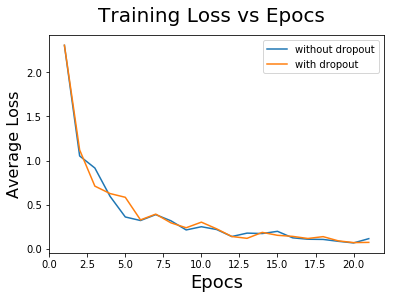

In [146]:
import matplotlib.pyplot as plt
iters = np.arange(epocs+1)+1

fig = plt.figure()

plt.plot(iters, np.array(loss_t[0]))
#plt.plot(iters, np.array(relu_t))
plt.plot(iters, np.array(a))
#plt.plot(iters, np.array(loss_t[2]))
#plt.plot(iters, np.array(loss_t[3]))

fig.suptitle('Training Loss vs Epocs', fontsize=20)
plt.xlabel('Epocs', fontsize=18)
plt.ylabel('Average Loss', fontsize=16)

plt.legend(["without dropout","with dropout"], loc='upper right')
plt.show()

In [89]:
relu_t=[]
relu_v=[]
relu_t=loss_t[2].copy()
relu_v=loss_v[2].copy()

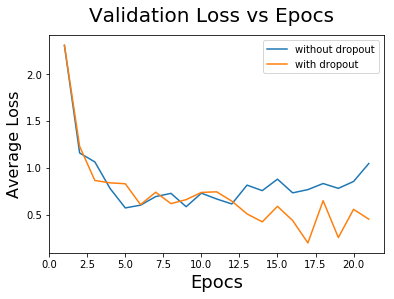

In [210]:
import matplotlib.pyplot as plt
iters = np.arange(epocs+1)+1

fig = plt.figure()

plt.plot(iters, np.array(loss_v[0]))
#plt.plot(iters, np.array(relu_v))
plt.plot(iters, np.array(b))
# plt.plot(iters, np.array(loss_v[2]))
# plt.plot(iters, np.array(loss_v[3]))

fig.suptitle('Validation Loss vs Epocs', fontsize=20)
plt.xlabel('Epocs', fontsize=18)
plt.ylabel('Average Loss', fontsize=16)

plt.legend(["without dropout","with dropout"], loc='upper right')
plt.show()

In [149]:
ypre=[]
for i in range(images1.shape[0]):
    ypre.append(predict(images1[i]))
from sklearn.metrics import accuracy_score
print(accuracy_score(labels1, ypre))

0.9988545454545454


In [ ]:
plt.imshow(np.reshape(imag2[100],[28,28]),'gray')

In [ ]:
plt.imshow(np.reshape(images2[4],[28,28]),'gray')

In [150]:
ypre=[]
for o in range(images2.shape[0]):
    ypre.append(predict(images2[o]))
#from sklearn.metrics import accuracy_score
print(accuracy_score(labels2, ypre))

0.944


In [ ]:
data1 = pd.read_csv("valid.csv")

sub_data1 = data1 #partial data
sub_data1 = sub_data1.values
print(sub_data1[0].shape)

ids = sub_data1[:,1]
print(ids.shape)

images2 = sub_data1[:,1:-1]
print(images2.shape)

labels2 = sub_data1[:,-1]
print(labels2.shape)

labels2 = labels2.astype(np.int64)

import sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(images2)
images2 = scaler.transform(images2)

images2 = pca.transform(images2)

ypre1=[]
for i in range(images2.shape[0]):
    ypre1.append(predict(images2[i]))
from sklearn.metrics import accuracy_score
print(accuracy_score(labels2, ypre1))

In [146]:
data3 = pd.read_csv("test.csv")

sub_data3 = data3 #partial data
sub_data3 = sub_data3.values
print(sub_data3[0].shape)

ids3 = sub_data3[:,0]
print(ids3.shape)

images3 = sub_data3[:,1:]
print(images3.shape)

images3=np.reshape(images3,[images3.shape[0],28,28])
imag3=images3.copy()
for i in range(images3.shape[0]):
    imag3[i]=preprocessing(images3[i])
    print(i)
images3=imag3.copy()
images3=np.reshape(images3,[images3.shape[0],28*28])
import sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(images3)
images3 = scaler.transform(images3)

images3 = pca.transform(images3)


ypre3=[]
for i in range(images3.shape[0]):
    ypre3.append(predict(images3[i]))

ids3 = ids3.astype(np.int64)
df = pd.DataFrame({'id':ids3,'label':ypre3})
df.to_csv("submission52.csv", encoding="utf-8", index=False)

(785,)
(10000,)
(10000, 784)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
2

3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873


5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873


7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871
7872


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
plt.imshow(np.reshape(images3[100],[28,28]),'gray')